In [2]:
import os
import math
import warnings
from tqdm import tqdm

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output

import cv2
from ultralytics import YOLO

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.optim import Adam, Optimizer
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import TensorDataset, DataLoader, random_split

from scipy.interpolate import griddata, NearestNDInterpolator
from scipy.ndimage import gaussian_laplace
from sklearn.preprocessing import MinMaxScaler

warnings.filterwarnings("ignore")

# Загрузка данных

In [112]:
file_path = '192.168.25.105_1710930733.txt'
# file_path = 'Data/192.168.13.103_1742466645.txt'
points = []

z_scaler = MinMaxScaler()
grd_mag_scaler = MinMaxScaler()

with open(file_path, 'r') as file:
    for x, line in enumerate(file):
        numbers = line.strip().split()

        for i in range(0, len(numbers), 2):
            if i + 1 < len(numbers):
                y = float(numbers[i])
                z = float(numbers[i + 1])

                if 1 < z < 280:  # TODO определить порог
                    points.append([x, y, z])

points = pd.DataFrame(points, columns=['X', 'Y', 'Z'])
points['Y'] -= points['Y'].min()
points['Z'] = z_scaler.fit_transform(points['Z'].to_numpy().reshape(-1, 1))
points

,X,Y,Z
0,0,17.0,0.176958
1,0,18.0,0.180117
2,0,19.0,0.183276
3,0,20.0,0.185421
4,0,21.0,0.186733
...,...,...,...
1365085,1494,941.0,0.450232
1365086,1494,942.0,0.447967
1365087,1494,943.0,0.446179
1365088,1494,944.0,0.444451


Создаём **points_full** - **points** приведённый к форме прямоугольника

In [113]:
all_y = sorted(points['Y'].unique())
all_x = sorted(points['X'].unique())

full_index = pd.MultiIndex.from_product([all_x, all_y], names=['X', 'Y'])
points_full = points.set_index(['X', 'Y']).reindex(full_index).reset_index()
points_full['Z'] = points_full['Z'].where(pd.notnull(points_full['Z']), None)
points_full.head()

,X,Y,Z
0,0,0.0,NaN
1,0,3.0,NaN
2,0,5.0,NaN
3,0,7.0,NaN
4,0,9.0,NaN


Добавляем к **points_full** столбец c мощностью градиента в точке

In [114]:
z_for_grad = points_full['Z'].to_numpy().reshape(points_full['X'].nunique(), points_full['Y'].nunique())
dy, dx = np.gradient(z_for_grad)

gradient_magnitude = np.sqrt(dx ** 2 + dy ** 2)
points_full['grd_mag'] = grd_mag_scaler.fit_transform(gradient_magnitude.reshape(-1, 1))
points_full.head()

,X,Y,Z,grd_mag
0,0,0.0,NaN,NaN
1,0,3.0,NaN,NaN
2,0,5.0,NaN,NaN
3,0,7.0,NaN,NaN
4,0,9.0,NaN,NaN


# Анализ изображений (высоты + градиенты)

### Графики

#### С пропусками

In [115]:
z_pivot = points_full.pivot(index='X', columns='Y', values='Z')
grad_magnitude_pivot = points_full.pivot(index='X', columns='Y', values='grd_mag')

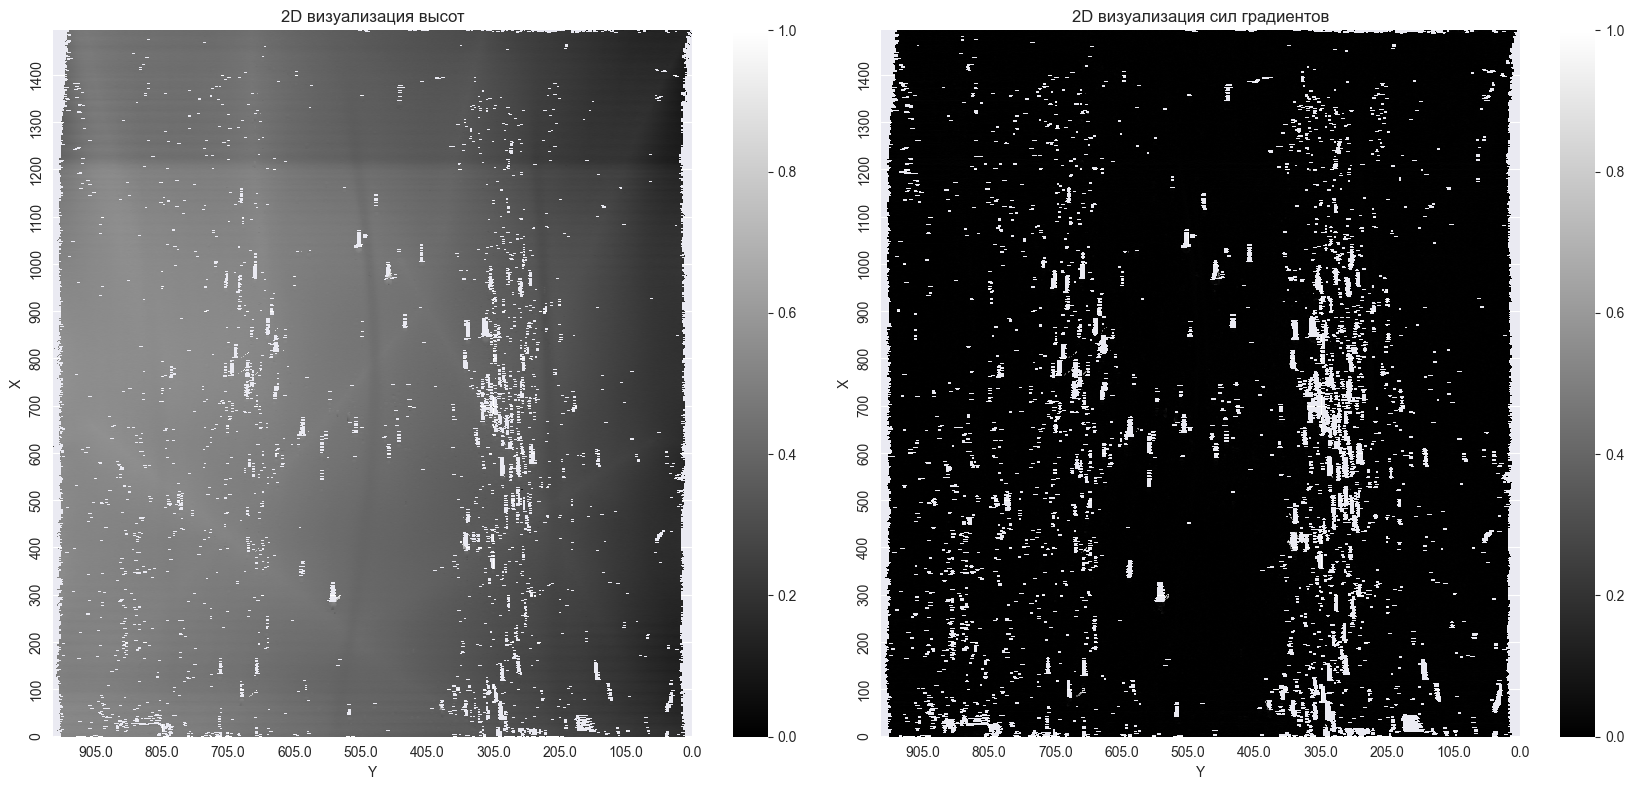

In [116]:
_, ax = plt.subplots(1, 2, figsize=(17, 8))

ax[0].set_xlabel('Y')
ax[0].set_ylabel('X')
ax[0].set_title('2D визуализация высот')

z = points_full['Z']
sns.heatmap(z_pivot, cmap='grey',
            vmin=np.nanmin(z), vmax=np.nanmax(z), ax=ax[0], cbar=True,
            xticklabels=100, yticklabels=100)

ax[0].invert_yaxis()
ax[0].invert_xaxis()

ax[1].set_xlabel('Y')
ax[1].set_ylabel('X')
ax[1].set_title('2D визуализация сил градиентов')

grad_magnitude = points_full['grd_mag']
sns.heatmap(grad_magnitude_pivot, cmap='grey',
            vmin=np.nanmin(grad_magnitude), vmax=np.nanmax(grad_magnitude), ax=ax[1], cbar=True,
            xticklabels=100, yticklabels=100)

ax[1].invert_yaxis()
ax[1].invert_xaxis()

plt.tight_layout()
plt.show()

#### Без пропусков

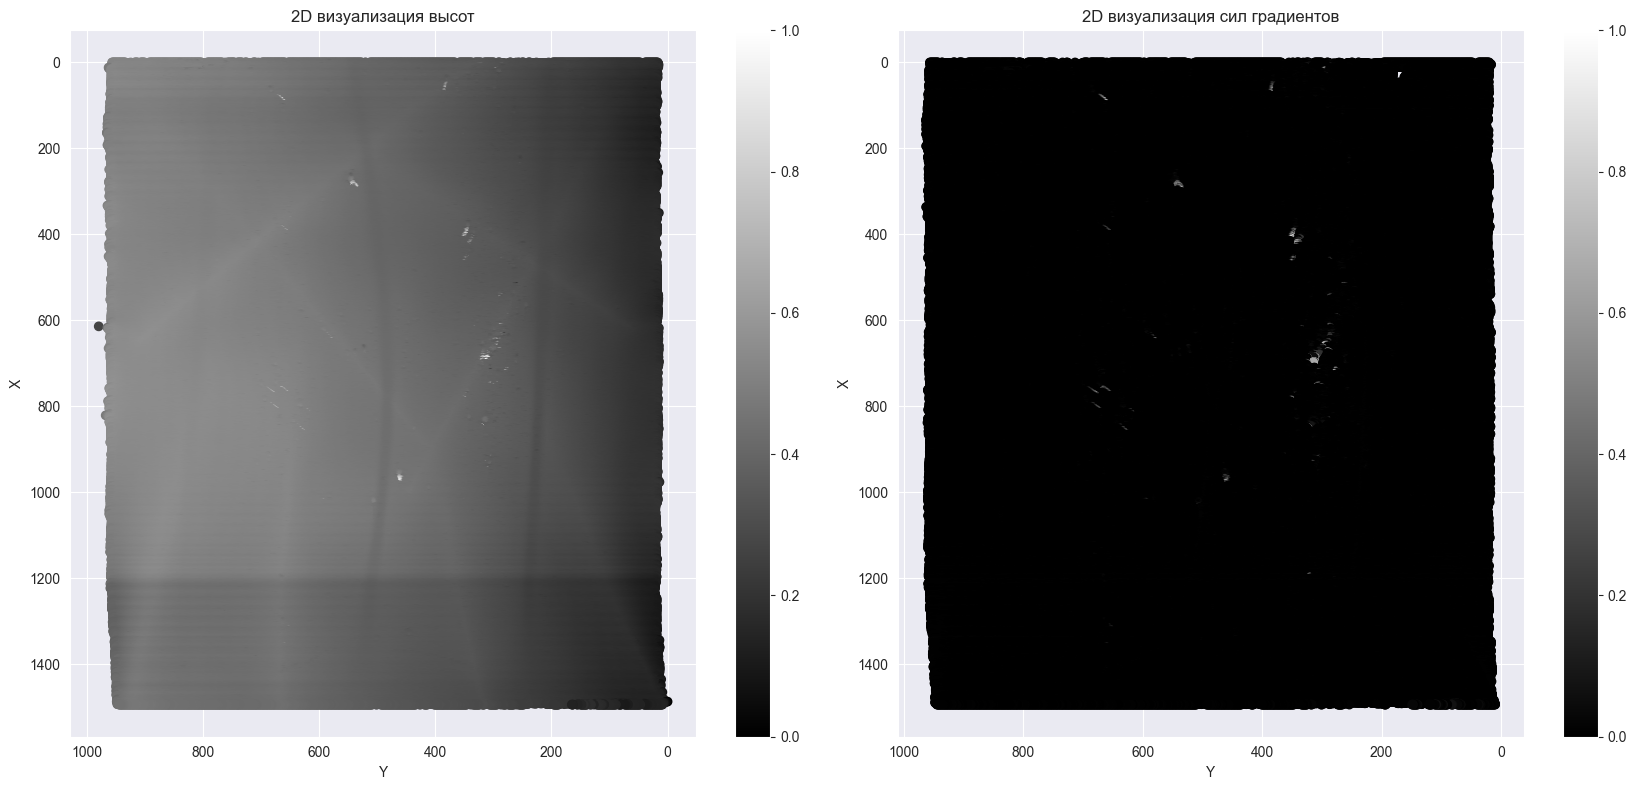

In [117]:
fig, ax = plt.subplots(1, 2, figsize=(17, 8))

ax[0].set_xlabel('Y')
ax[0].set_ylabel('X')
ax[0].set_title('2D визуализация высот')

plot_points = points_full.dropna(subset=['Z'])
x = plot_points['X']
y = plot_points['Y']
z = plot_points['Z']

scatter1 = ax[0].scatter(y, x, c=z, cmap='grey',
                         vmin=min(z), vmax=max(z))
fig.colorbar(scatter1, ax=ax[0])
ax[0].invert_yaxis()
ax[0].invert_xaxis()

ax[1].set_xlabel('Y')
ax[1].set_ylabel('X')
ax[1].set_title('2D визуализация сил градиентов')

plot_points = points_full.dropna(subset=['grd_mag'])
x = plot_points['X']
y = plot_points['Y']
grd_magnitude = plot_points['grd_mag']

scatter2 = ax[1].scatter(y, x, c=grd_magnitude, cmap='grey',
                         vmin=min(grd_magnitude), vmax=max(grd_magnitude))
fig.colorbar(scatter2, ax=ax[1])
ax[1].invert_yaxis()
ax[1].invert_xaxis()

plt.tight_layout()
plt.show()

#### С интерполяцией

##### Высоты

In [118]:
X = points_full['X'].values
Y = points_full['Y'].values
Z = points_full['Z'].values

mask = ~np.isnan(Z)
X_known, Y_known, Z_known = X[mask], Y[mask], Z[mask]

interp = NearestNDInterpolator(list(zip(X_known, Y_known)), Z_known)
Z_filled = interp(X, Y)

grid_x, grid_y = np.mgrid[min(X):max(X), min(Y):max(Y)]
z_map = griddata((X, Y), Z_filled, (grid_x, grid_y), method='cubic')
z_map

array([[0.16795794, 0.16795991, 0.16796041, ..., 0.48608394, 0.48188506,
        0.47749475],
       [0.16795794, 0.16795796, 0.1679614 , ..., 0.48841997, 0.48340909,
        0.47821946],
       [0.16795794, 0.16797208, 0.16796857, ..., 0.47325648, 0.47248207,
        0.47237746],
       ...,
       [0.00739063, 0.03613646, 0.06075645, ..., 0.42761193, 0.42751117,
        0.42740074],
       [0.00739063, 0.03166017, 0.05372297, ..., 0.42727182, 0.42729626,
        0.4273029 ],
       [0.04368814, 0.04940137, 0.06068087, ..., 0.42294625, 0.4245806 ,
        0.42607795]], shape=(1494, 980))

In [119]:
# valid_points = points_full.dropna(subset=['Z'])
# 
# X = valid_points['X'].values
# Y = valid_points['Y'].values
# Z = valid_points['Z'].values
# grid_x, grid_y = np.mgrid[min(X):max(X), min(Y):max(Y)]
# 
# z_map = griddata((X, Y), Z, (grid_x, grid_y), method='cubic')

In [175]:
z_log = gaussian_laplace(z_map, sigma=3)
z_log = np.nan_to_num(z_log)

# z_map = MinMaxScaler().fit_transform(z_map)
# z_log = MinMaxScaler().fit_transform(z_log)

z_map = pd.DataFrame(z_map, columns=range(int(min(Y)), int(max(Y))))
z_log = pd.DataFrame(z_log, columns=range(int(min(Y)), int(max(Y))))

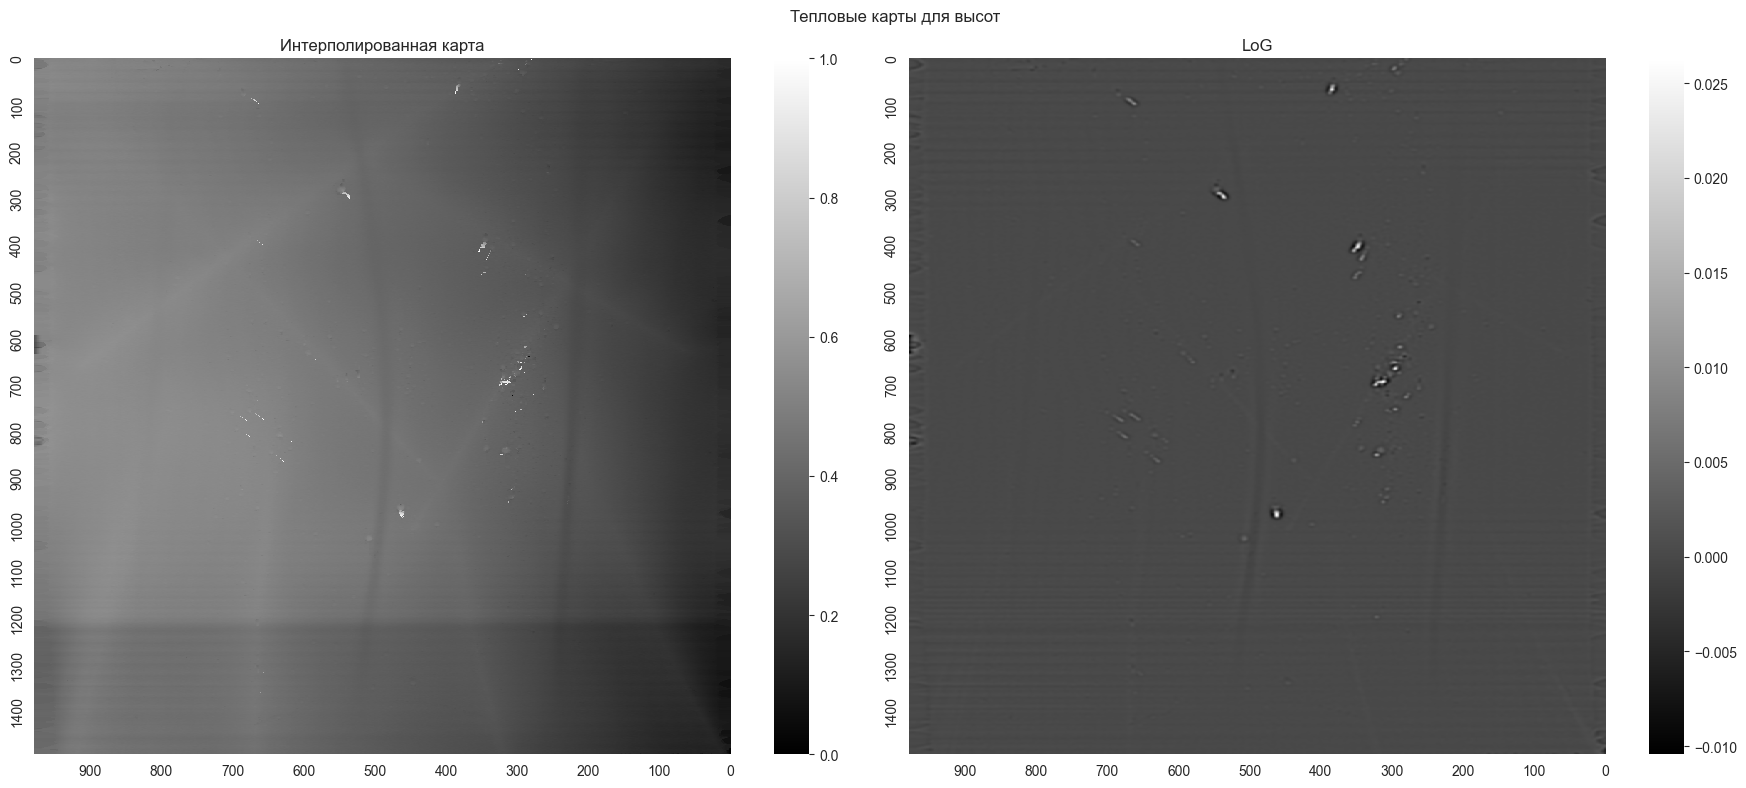

In [176]:
fig, ax = plt.subplots(1, 2, figsize=(18, 8))
fig.suptitle("Тепловые карты для высот")

sns.heatmap(z_map, cmap='grey', annot=False, xticklabels=100, yticklabels=100, cbar=True, ax=ax[0])
ax[0].set_title('Интерполированная карта')
ax[0].invert_xaxis()

sns.heatmap(-z_log, cmap='grey', annot=False, xticklabels=100, yticklabels=100, cbar=True, ax=ax[1])
ax[1].set_title('LoG')
ax[1].invert_xaxis()

plt.tight_layout()
plt.show()

##### Градиенты

In [122]:
X = points_full['X'].values
Y = points_full['Y'].values
grd_mag = points_full['grd_mag'].values

mask = ~np.isnan(grd_mag)
X_known, Y_known, grd_mag_known = X[mask], Y[mask], grd_mag[mask]

interp = NearestNDInterpolator(list(zip(X_known, Y_known)), grd_mag_known)
grd_mag_filled = interp(X, Y)

grid_x, grid_y = np.mgrid[min(X):max(X), min(Y):max(Y)]
grd_mag_map = griddata((X, Y), grd_mag_filled, (grid_x, grid_y), method='cubic')
grd_mag_map

array([[0.00714719, 0.00714716, 0.00714715, ..., 0.01453467, 0.01453801,
        0.01454305],
       [0.00714719, 0.00714698, 0.00714741, ..., 0.01452377, 0.01453186,
        0.01454073],
       [0.00714719, 0.0071497 , 0.00714902, ..., 0.01454179, 0.01453421,
        0.01453597],
       ...,
       [0.00136236, 0.00150047, 0.001535  , ..., 0.01181098, 0.01187426,
        0.01194361],
       [0.00136236, 0.00191989, 0.00142943, ..., 0.01194628, 0.01195748,
        0.01198003],
       [0.0161192 , 0.01546358, 0.01567886, ..., 0.01202654, 0.01202386,
        0.01202036]], shape=(1494, 980))

In [123]:
# valid_points = points_full.dropna(subset=['grd_mag'])
# 
# X = valid_points['X'].values
# Y = valid_points['Y'].values
# grd_magnitude = valid_points['grd_mag'].values
# 
# grid_x, grid_y = np.mgrid[min(X):max(X), min(Y):max(Y)]
# 
# grd_mag_map = griddata((X, Y), grd_magnitude, (grid_x, grid_y), method='cubic')

In [173]:
grd_mag_log = gaussian_laplace(grd_mag_map, sigma=3)
grd_mag_log = np.nan_to_num(grd_mag_log)

# grd_mag_map = MinMaxScaler().fit_transform(grd_mag_map)
# grd_mag_log = MinMaxScaler().fit_transform(grd_mag_log)

grd_mag_map = pd.DataFrame(grd_mag_map, columns=range(int(min(Y)), int(max(Y))))
grd_mag_log = pd.DataFrame(grd_mag_log, columns=range(int(min(Y)), int(max(Y))))

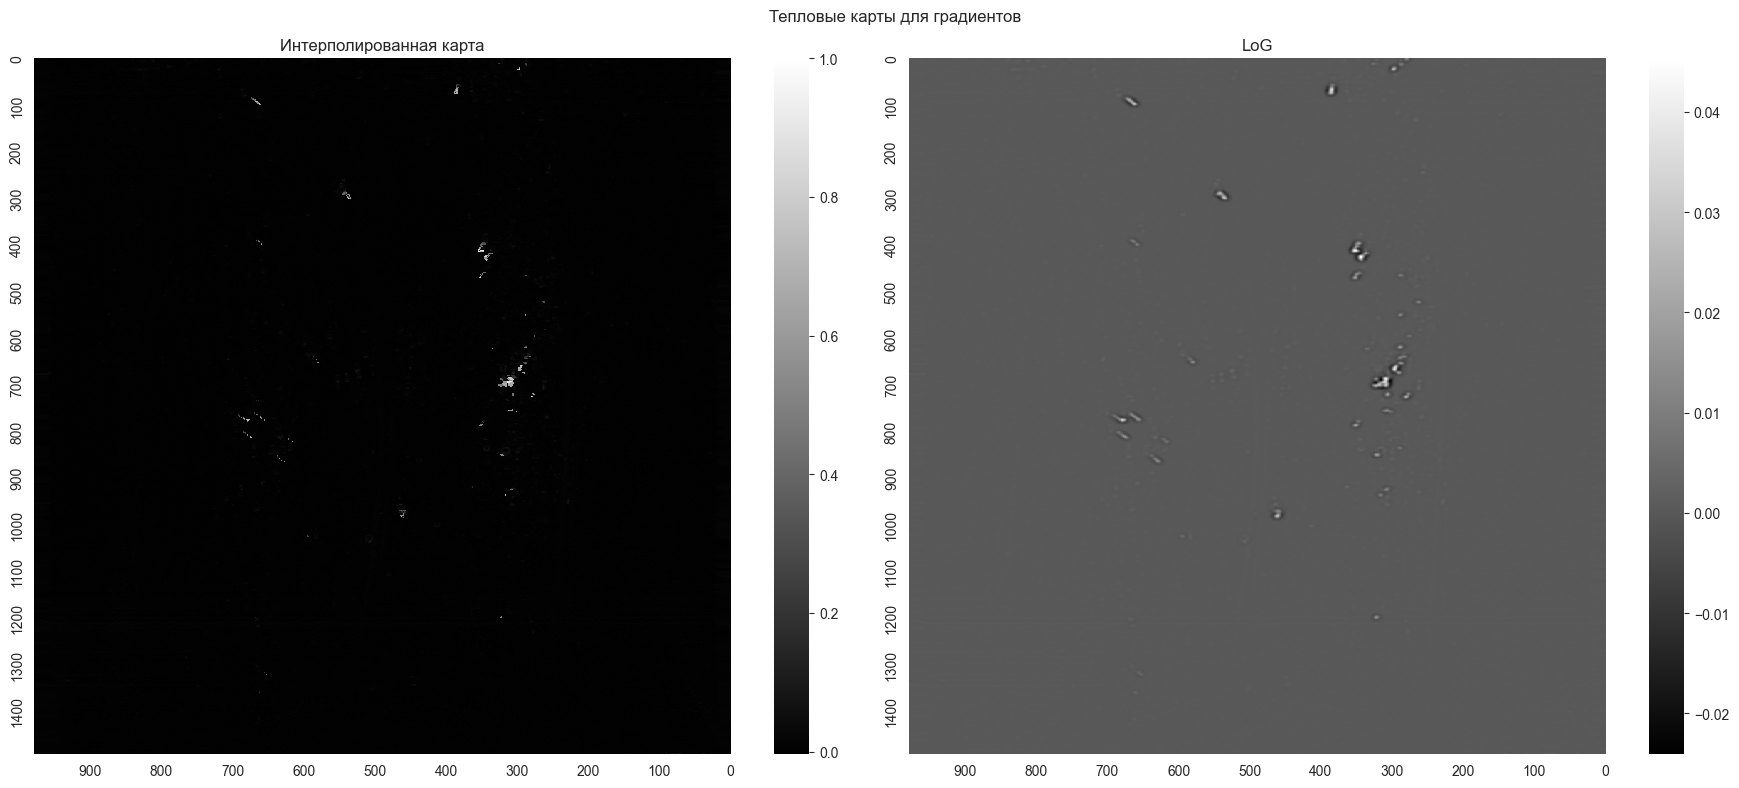

In [174]:
fig, ax = plt.subplots(1, 2, figsize=(18, 8))
fig.suptitle("Тепловые карты для градиентов")

sns.heatmap(grd_mag_map, cmap='grey', annot=False, xticklabels=100, yticklabels=100, cbar=True, ax=ax[0])
ax[0].set_title('Интерполированная карта')
ax[0].invert_xaxis()

sns.heatmap(-grd_mag_log, cmap='grey', annot=False, xticklabels=100, yticklabels=100, cbar=True, ax=ax[1])
ax[1].set_title('LoG')
ax[1].invert_xaxis()

plt.tight_layout()
plt.show()

# Контуры

!!! НАДО ПОДОБРАТЬ ПРАВИЛЬНЫЕ ПАРАМЕТРЫ

Функция для поиска/отрисовки контуров и соответствующих им bbox

In [126]:
def draw_contour_and_bbox(image, show=True):
    # blurred = cv2.GaussianBlur(image, (5, 5), 0)

    # clahe = cv2.createCLAHE(clipLimit=5)
    # image = clahe.apply(image)

    adaptive_thresh = cv2.adaptiveThreshold(
        image, 0,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY,
        3, 10
    )

    # kernel = np.ones((3, 3), np.uint8)
    # morph = cv2.morphologyEx(adaptive_thresh, cv2.MORPH_CLOSE, kernel, iterations=3)
    # 
    # contours, _ = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    contours, _ = cv2.findContours(adaptive_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    img_bgr = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    bboxes = []
    for contour in contours:
        # if cv2.contourArea(contour) > 1000:
        #     continue

        x, y, w, h = cv2.boundingRect(contour)

        cv2.drawContours(adaptive_thresh, [contour], -1, (0, 0, 255), 1)
        cv2.rectangle(adaptive_thresh, (x, y), (x + w, y + h), (0, 255, 0), 1)

        bboxes.append([x, y, x + w, y + h])

    if show:
        # cv2.namedWindow('Contours with BBoxes', cv2.WINDOW_NORMAL)
        cv2.imshow('Contours with BBoxes', image)
        # cv2.resizeWindow('Contours with BBoxes', img_bgr.shape[1], img_bgr.shape[0])
        # cv2.namedWindow('Contours with BBoxes', cv2.WINDOW_NORMAL)

        cv2.waitKey(0)
        cv2.destroyAllWindows()

    return bboxes

Функция для рассчета максимальной высоты дендрита в заданных областях

In [149]:
def get_max_height_from_bboxes(data, bboxes):
    max_height = float('-inf')

    for bbox in bboxes:
        x1, y1, x2, y2 = bbox

        filtered_points = data[
            (data["X"] >= x1) & (data["X"] <= x2) &
            (data["Y"] >= y1) & (data["Y"] <= y2)
            ].dropna(subset=["Z"])

        if len(filtered_points) > 1:
            max_height = max(max_height, filtered_points["Z"].max() - filtered_points["Z"].min())

    return round(max_height.item(), 2) if max_height != float('-inf') else None

## Высоты

### Интерполяция

In [128]:
# img = z_map.to_numpy()
# img_norm = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
# img_uint8 = img_norm.astype(np.uint8)
# bboxes = draw_contour_and_bbox(img_uint8)
# non_processed_res = get_max_height_from_bboxes(points, bboxes)
# z_scaler.inverse_transform(np.array(non_processed_res).reshape(-1, 1)) + z_scaler.data_min_

### LOG

In [129]:
# img = np.nan_to_num(-z_log.to_numpy(), nan=0)
# img_norm = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
# img_uint8 = img_norm.astype(np.uint8)
# bboxes = draw_contour_and_bbox(img_uint8)
# non_processed_res = get_max_height_from_bboxes(points, bboxes)
# z_scaler.inverse_transform(np.array(non_processed_res).reshape(-1, 1)) + z_scaler.data_min_

## Градиенты

### Интерполяция

In [150]:
img = grd_mag_map.to_numpy()
img_norm = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
img_uint8 = img_norm.astype(np.uint8)

bboxes = draw_contour_and_bbox(img_uint8)
non_processed_res = get_max_height_from_bboxes(points, bboxes)
z_scaler.inverse_transform(np.array(non_processed_res).reshape(-1, 1)) + z_scaler.data_min_

array([[nan]])

### LOG

In [151]:
img = np.nan_to_num(-grd_mag_log.to_numpy(), nan=0)
img_norm = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
img_uint8 = img_norm.astype(np.uint8)

bboxes = draw_contour_and_bbox(img_uint8)
non_processed_res = get_max_height_from_bboxes(points, bboxes)
z_scaler.inverse_transform(np.array(non_processed_res).reshape(-1, 1)) + z_scaler.data_min_

array([[nan]])

# CV

## Подготовка данных

Функция для LOG карты градиентов

In [6]:
def get_image_log(file_path):
    points = []

    with open(file_path, 'r') as file:
        for x, line in enumerate(file):
            numbers = line.strip().split()

            for i in range(0, len(numbers), 2):
                if i + 1 < len(numbers):
                    y = float(numbers[i])
                    z = float(numbers[i + 1])

                    if 1 < z < 280:
                        points.append([x, y, z])

    points = pd.DataFrame(points, columns=['X', 'Y', 'Z'])
    points['Y'] -= points['Y'].min()

    all_y = sorted(points['Y'].unique())
    all_x = sorted(points['X'].unique())

    full_index = pd.MultiIndex.from_product([all_x, all_y], names=['X', 'Y'])
    points_full = points.set_index(['X', 'Y']).reindex(full_index).reset_index()
    points_full['Z'] = points_full['Z'].where(pd.notnull(points_full['Z']), None)

    z_for_grad = points_full['Z'].to_numpy().reshape(points_full['X'].nunique(), points_full['Y'].nunique())
    dy, dx = np.gradient(z_for_grad)

    gradient_magnitude = np.sqrt(dx ** 2 + dy ** 2)
    grd_mag_scaler = MinMaxScaler()
    points_full['grd_mag'] = grd_mag_scaler.fit_transform(gradient_magnitude.reshape(-1, 1))

    X = points_full['X'].values
    Y = points_full['Y'].values
    grd_mag = points_full['grd_mag'].values

    mask = ~np.isnan(grd_mag)
    X_known, Y_known, grd_mag_known = X[mask], Y[mask], grd_mag[mask]

    interp = NearestNDInterpolator(list(zip(X_known, Y_known)), grd_mag_known)
    grd_mag_filled = interp(X, Y)

    grid_x, grid_y = np.mgrid[min(X):max(X), min(Y):max(Y)]
    grd_mag_map = griddata((X, Y), grd_mag_filled, (grid_x, grid_y), method='cubic')

    grd_mag_log = gaussian_laplace(grd_mag_map, sigma=3)

    return points_full, grd_mag_log

In [158]:
files_dir = 'Data'
files = [os.path.join(files_dir, f) for f in os.listdir(files_dir)]

output_dir = 'CV_3D/photos'
os.makedirs(output_dir, exist_ok=True)

start_i = 107

for i, file in tqdm(enumerate(files), total=len(files)):

    if i < start_i:
        continue

    _, current_img = get_image_log(file)
    current_img = cv2.normalize(current_img, None, 0, 255, cv2.NORM_MINMAX)
    current_img = current_img.astype(np.uint8)
    cv2.imwrite(output_dir + f'/image_{i}.png', current_img)

 15%|█▍        | 108/726 [21:44<2:04:22, 12.08s/it]


KeyboardInterrupt: 

## Классификатор 36x36

### Модель

In [34]:
class BaseCNN36(nn.Module):
    def __init__(self, input_size=36):
        super(BaseCNN36, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )

        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(64, 2)

    def forward(self, x, return_features=False):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        features = x.view(x.size(0), -1)
        features = self.dropout(features)
        out = self.fc(features)

        if return_features:
            return out, features
        return out


In [35]:
model = BaseCNN36(input_size=36)
dummy_input = torch.randn(8, 1, 36, 36)

logits, features = model(dummy_input, return_features=True)

print("Logits shape:", logits.shape)
print("Features shape:", features.shape)

Logits shape: torch.Size([8, 2])
Features shape: torch.Size([8, 64])


### Аннотирование

Функция для действий при нажатии на клавиши мыши

In [7]:
def click_event(event, x, y, flags, params):
    global data

    if event == cv2.EVENT_LBUTTONDOWN:
        x1, y1 = x - 18, y - 18
        x2, y2 = x + 18, y + 18

        new_row = pd.Series({'x1': x1, 'y1': y1, 'x2': x2, 'y2': y2, 'label': None})
        data = pd.concat([data, new_row.to_frame().T], ignore_index=True)
        print(f'Добавил прямоугольник ({x1},{y1},{x2},{y2}')

Функция для действий при нажатии на кнопку

In [8]:
def key_event():
    global data
    while True:
        key = cv2.waitKey(0) & 0xFF
        idx = data[data['label'].isnull()].last_valid_index()

        if key == ord('w') and idx is not None:
            data.at[idx, 'label'] = 1
            print('label = 1')
        elif key == ord('s') and idx is not None:
            data.at[idx, 'label'] = 0
            print('label = 0')
        elif key == ord('t'):
            save_patches()
            return 'continue'
        elif key == ord('q'):
            save_all_tensors()
            return 'end'

Функция для сохранения патчей

In [9]:
def save_patches():
    global current_img, data, all_tensors, all_labels, all_images

    for i, row in data.iterrows():
        if pd.isnull(row[['x1', 'y1', 'x2', 'y2', 'label']]).any():
            continue

        x1, y1, x2, y2 = map(int, [row['x1'], row['y1'], row['x2'], row['y2']])

        if x1 < 0:
            x1, x2 = 0, x2 - x1

        if y1 < 0:
            y1, y2 = 0, y2 - y1

        patch = current_img[y1:y2, x1:x2]
        patch = cv2.resize(patch, (36, 36))
        patch = cv2.cvtColor(patch, cv2.COLOR_BGR2GRAY)

        # TODO надо потестить

        # patch = cv2.adaptiveThreshold(
        #     patch, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        #     cv2.THRESH_BINARY, 11, 2
        # )

        patch_tensor = torch.tensor(patch, dtype=torch.float32).unsqueeze(0)

        # patch_tensor /= 255.0

        all_tensors.append(patch_tensor)
        all_labels.append(int(row["label"]))
        all_images.append(patch)

    data = pd.DataFrame(columns=['x1', 'y1', 'x2', 'y2', 'label'])

Функция для сохранения финальных тензоров

In [10]:
def save_all_tensors():
    global all_tensors, all_labels
    try:
        all_tensors_tensor = torch.stack(all_tensors)
        torch.save(all_tensors_tensor, 'CV_3D/Train/images.pt')
        torch.save(all_labels, 'CV_3D/Train/labels.pt')
        print(f'Сохранены все тензоры и лейблы - {len(all_labels)}')

        for i, image in enumerate(all_images):
            cv2.imwrite(f'CV_3D/Train/Images/image_{i}.png', image)

    except Exception as e:
        print('Данные не были сохранены')

In [15]:
data = pd.DataFrame(columns=['x1', 'y1', 'x2', 'y2', 'label'])

photo_dir = 'CV_3D/photos'
photos = [os.path.join(photo_dir, f) for f in os.listdir(photo_dir)]

output_dir = 'CV_3D/Train'
os.makedirs(output_dir, exist_ok=True)

current_img = None

all_tensors = []
all_labels = []
all_images = []

for photo in photos:

    frame_name = photo.split("\\")[-1]

    current_img = cv2.imread(photo)
    cv2.namedWindow(frame_name, cv2.WINDOW_NORMAL)
    cv2.imshow(frame_name, current_img)

    cv2.setMouseCallback(frame_name, click_event)
    res = key_event()

    cv2.destroyAllWindows()

    if res == 'end':
        break

Добавил прямоугольник (804,477,840,513
label = 1
Добавил прямоугольник (767,1389,803,1425
label = 1
Добавил прямоугольник (801,1521,837,1557
label = 1
Добавил прямоугольник (642,1443,678,1479
label = 1
Добавил прямоугольник (805,474,841,510
label = 1
Добавил прямоугольник (112,29,148,65
label = 1
Добавил прямоугольник (97,25,133,61
label = 1
Добавил прямоугольник (142,24,178,60
label = 1
Добавил прямоугольник (176,29,212,65
label = 1
Добавил прямоугольник (186,29,222,65
label = 1
Добавил прямоугольник (-2,369,34,405
label = 0
Добавил прямоугольник (1,505,37,541
label = 0
Добавил прямоугольник (-5,633,31,669
label = 0
Добавил прямоугольник (-4,782,32,818
label = 0
Добавил прямоугольник (401,1122,437,1158
label = 0
Добавил прямоугольник (374,974,410,1010
label = 0
Добавил прямоугольник (407,613,443,649
label = 0
Добавил прямоугольник (398,462,434,498
label = 0
Добавил прямоугольник (227,1523,263,1559
label = 0
Добавил прямоугольник (441,1521,477,1557
label = 0
Добавил прямоугольник (932,

In [16]:
save_all_tensors()

Сохранены все тензоры и лейблы - 684


### Обучение

Функция обучения

In [162]:
def train(
        model: nn.Module,
        data_loader: DataLoader,
        optimizer: Optimizer,
        loss_fn,
        device: torch.device,
) -> tuple[float, float]:
    model.train()

    total_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(data_loader, desc="Train"):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()

        output = model(x)

        loss = loss_fn(output, y)

        loss.backward()

        total_loss += loss.item()

        optimizer.step()

        _, y_pred = torch.max(output, 1)
        total += y.size(0)
        correct += (y_pred == y).sum().item()

    return total_loss / len(data_loader), correct / total

Функция для валидации

In [163]:
@torch.inference_mode()
def evaluate(
        model: nn.Module, data_loader: DataLoader, loss_fn, device: torch.device
) -> tuple[float, float]:
    model.eval()

    total_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(data_loader, desc="Evaluate"):
        x, y = x.to(device), y.to(device)

        output = model(x)

        loss = loss_fn(output, y)

        total_loss += loss.item()

        _, y_pred = torch.max(output, 1)
        total += y.size(0)
        correct += (y_pred == y).sum().item()

    return total_loss / len(data_loader), correct / total

Функция для вывода статистики

In [164]:
def plot_stats(
        train_loss: list[float],
        valid_loss: list[float],
        train_accuracy: list[float],
        valid_accuracy: list[float],
        title: str,
):
    plt.figure(figsize=(16, 8))

    plt.title(title + " loss")

    plt.plot(train_loss, label="Train loss")
    plt.plot(valid_loss, label="Valid loss")
    plt.legend()
    plt.grid()

    plt.show()

    plt.figure(figsize=(16, 8))

    plt.title(title + " accuracy")

    plt.plot(train_accuracy, label="Train accuracy")
    plt.plot(valid_accuracy, label="Valid accuracy")
    plt.legend()
    plt.grid()

    plt.show()

Функция для цикла обучения и валидации

In [165]:
def whole_train_valid_cycle(
        model, train_loader, valid_loader, optimizer, loss_fn, scheduler, device, threshold, title
):
    train_loss_history, valid_loss_history = [], []
    train_accuracy_history, valid_accuracy_history = [], []

    for epoch in range(100):
        train_loss, train_accuracy = train(
            model, train_loader, optimizer, loss_fn, device
        )
        valid_loss, valid_accuracy = evaluate(model, valid_loader, loss_fn, device)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        train_accuracy_history.append(train_accuracy)
        valid_accuracy_history.append(valid_accuracy)

        clear_output(wait=True)

        plot_stats(
            train_loss_history,
            valid_loss_history,
            train_accuracy_history,
            valid_accuracy_history,
            title,
        )

        scheduler.step()

        if valid_accuracy >= threshold:
            break

Запуск обучения

In [36]:
images = torch.load('CV_3D/Train/images.pt')
labels = torch.load('CV_3D/Train/labels.pt')

if not isinstance(labels, torch.Tensor):
    labels = torch.tensor(labels)

# transform = transforms.Compose([
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(10),
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2)
# ])

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomErasing(p=0.2)
])

images = images.float() / 255.0

transformed_images = torch.stack([transform(img) for img in images])
full_dataset = TensorDataset(transformed_images, labels)

val_ratio = 0.2
val_size = int(len(full_dataset) * val_ratio)
train_size = len(full_dataset) - val_size

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = BaseCNN36(input_size=36).to(device)

optimizer = Adam(model.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=20, gamma=0.1)

loss_fn = nn.CrossEntropyLoss()

whole_train_valid_cycle(
    model, train_loader, valid_loader, optimizer, loss_fn, scheduler, device, threshold=1, title='CNN'
)

torch.save(model.state_dict(), "CV_3D/model.pt")

NameError: name 'whole_train_valid_cycle' is not defined

### Инференс тест

In [ ]:
images = torch.load('CV_3D/Train/images.pt')
labels = torch.load('CV_3D/Train/labels.pt')

if not isinstance(labels, torch.Tensor):
    labels = torch.tensor(labels)

images = images.float() / 255.0

full_dataset = TensorDataset(images, labels)

val_ratio = 0.2
val_size = int(len(full_dataset) * val_ratio)
train_size = len(full_dataset) - val_size

_, val_dataset = random_split(full_dataset, [train_size, val_size])

val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = BaseCNN36(input_size=36).to(device)
model.load_state_dict(torch.load('CV_3D/model.pt'))
model.eval()

all_logits = []
all_preds = []
all_labels = []
all_features = []

with torch.no_grad():
    for batch_imgs, batch_labels in val_loader:
        batch_imgs, batch_labels = batch_imgs.to(device), batch_labels.to(device)
        logits, features = model(batch_imgs, return_features=True)
        preds = torch.argmax(F.softmax(logits, dim=1), dim=1)

        all_logits.append(logits.cpu())
        all_preds.append(preds.cpu())
        all_labels.append(batch_labels.cpu())
        all_features.append(features.cpu())

all_logits = torch.cat(all_logits)
all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)
all_features = torch.cat(all_features)

print(f'Accuracy - {round((all_preds == all_labels).float().mean().item(), 2)}')

Посмотрим на фичи

In [ ]:
images = torch.load('CV_3D/Train/images.pt')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

images = images.float() / 255.0

img = images[1].unsqueeze(0).to(device)

model = BaseCNN36(input_size=36).to(device)
model.load_state_dict(torch.load('CV_3D/model.pt'))
model.eval()

with torch.no_grad():
    x = model.conv1(img)
    features = x.squeeze(0).cpu()

features = features.squeeze(0).cpu()

fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(features[i], cmap='gray')
    ax.set_title(f'Канал {i}')
    ax.axis('off')

plt.suptitle('Активации после последнего сверточного слоя')
plt.tight_layout()
plt.show()

### Инференс прод

In [ ]:
file_path = "192.168.25.105_1710930733.txt"
# file_path = "Data/192.168.13.103_1742463834.txt"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = BaseCNN36(input_size=36).to(device)
model.load_state_dict(torch.load('CV_3D/model.pt'))
model.eval()

image_data, image = get_image_log(file_path=file_path)
image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)
image = image / 255.0
image_np = np.array(image)

transform = transforms.Compose([
    transforms.ToTensor()
])

stride = 18
window_size = 36
arr = np.zeros((math.floor((image_np.shape[0] - window_size) / stride) + 1,
                math.floor((image_np.shape[1] - window_size) / stride) + 1))

positive_images = []
positive_images_bbox = []

for i, y in enumerate(range(0, image_np.shape[0] - window_size + 1, stride)):
    for j, x in enumerate(range(0, image_np.shape[1] - window_size + 1, stride)):
        patch = image_np[y:y + window_size, x:x + window_size]
        patch_tensor = transform(patch).unsqueeze(0).float().to(device)

        with torch.no_grad():
            output = model(patch_tensor)
            pred = torch.argmax(output, dim=1).item()

        if pred:
            positive_images.append(patch)
            positive_images_bbox.append([x, y, x + window_size, y + window_size])

        arr[i, j] = pred

fig, ax = plt.subplots(1, 2, figsize=(17, 8))

sns.heatmap(arr, ax=ax[0], vmin=0, vmax=1)

imshow = ax[1].imshow(image_np)
fig.colorbar(imshow, ax=ax[1])
ax[1].axis('off')

plt.tight_layout()
plt.show()

In [8]:
len(positive_images)

69

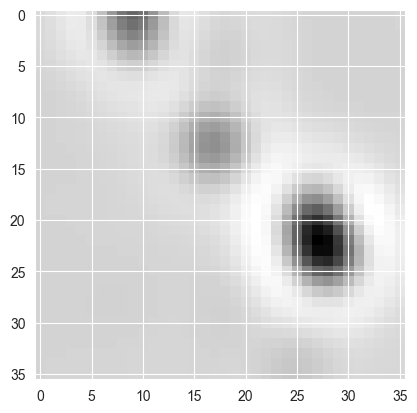

In [17]:
plt.imshow(positive_images[0], cmap='gray')

### Пробуем определять высоту

In [26]:
z = pd.DataFrame()


def get_max_height_from_bboxes(image_data, bboxes):
    global z
    max_height = float('-inf')

    for i, bbox in enumerate(bboxes):
        x1, y1, x2, y2 = bbox

        filtered_points = image_data[
            (image_data["X"] >= x1) & (image_data["X"] <= x2) &
            (image_data["Y"] >= y1) & (image_data["Y"] <= y2)
            ].dropna(subset=["Z"])
        
        filtered_points['id'] = i
        z = pd.concat([z, filtered_points], axis=0)

        if len(filtered_points) > 1:
            print(filtered_points["Z"].max() - filtered_points["Z"].min())
            max_height = max(max_height, filtered_points["Z"].max() - filtered_points["Z"].min())

    return round(max_height.item(), 2) if max_height != float('-inf') else None


get_max_height_from_bboxes(image_data, positive_images_bbox)

4.268000000000001
4.471700000000002
5.4223
5.228299999999997
3.6278000000000006
3.7441999999999958
5.334999999999994
5.334999999999994
5.887900000000002
5.558099999999996
5.373799999999996
5.509599999999999
80.2867
5.975199999999994
80.42249999999999
5.131300000000003
4.859699999999997
4.879099999999994
3.559899999999999
3.2301000000000073
3.1525000000000034
3.133099999999999
2.9003000000000014
3.1525000000000034
3.0652000000000044
2.9488000000000056
3.0748999999999995
69.92779999999999
4.287400000000005
3.7151000000000067
3.5792999999999893
4.3553
9.011299999999991
3.394999999999996
3.5016999999999996
3.2979999999999876
3.608400000000003
2.793599999999998
3.6665999999999883
3.055499999999995
6.789999999999992
7.498099999999994
3.9575999999999993
3.9284999999999997
4.015799999999999
3.7442000000000064
4.083699999999993
3.1912999999999982
2.8712000000000018
2.715999999999994
3.2494999999999976
3.2494999999999976
3.5308000000000135
2.842100000000002
2.9876000000000005
6.4698999999999955


80.42

Можно заметить большие выбросы, хз что делать пока :(

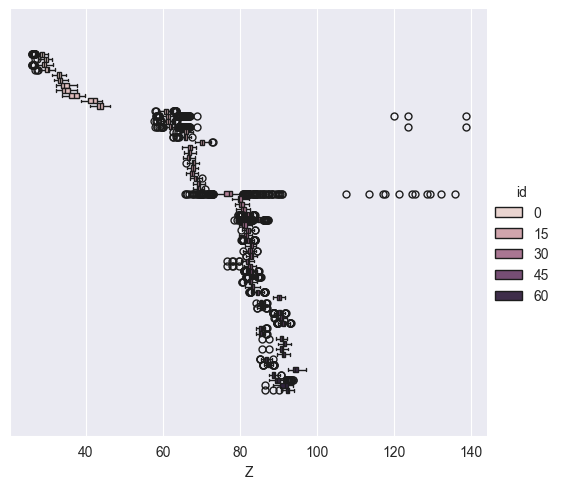

In [30]:
sns.catplot(x=z['Z'], hue=z['id'], kind='box')

## Классификатор 24x24

## YOLO - хз может и нет смысла

### Модель

In [184]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

yolo_model = YOLO('YOLO/models/yolo11n.pt')

### Аннотирование

Делал в **RoboFlow** 

#todo добавить ссылку

### Обучение

In [ ]:
yolo_model.train(data="PlateRecognition/LicensePlateDetector/data.yaml", epochs=100, imgsz=640)